In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from scipy.stats import norm
import seaborn as sns
import scipy.integrate

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [3]:
mean=0
std_dev=1
x=np.random.normal(mean,std_dev,400)
x=np.sort(x)

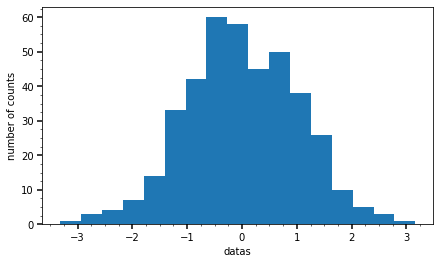

In [4]:
fig, isto = plt.subplots(figsize=(7, 4))
isto.hist(x,bins='auto',histtype='bar')
isto.set_ylabel('number of counts')
isto.set_xlabel('datas')

def major_tick(x, pos):
    if not x%1.:
        return "%d" %x
    return "%.2f" % x

isto.xaxis.set_major_locator(MultipleLocator(1))
isto.xaxis.set_minor_locator(AutoMinorLocator(4))
isto.yaxis.set_major_locator(MultipleLocator(10))
isto.yaxis.set_minor_locator(AutoMinorLocator(4))
isto.yaxis.set_major_formatter(FuncFormatter(major_tick))

isto.tick_params(which='major', width=1.5)
isto.tick_params(which='major', length=5)


152.44611201417976
390.26193928360163
2.5599992950118757


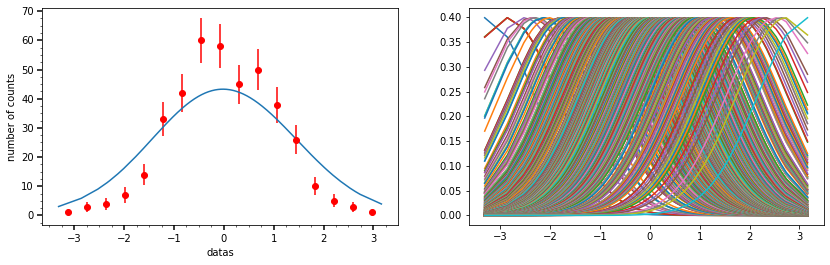

In [12]:
fig, (isto, plotto) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

n_x, binz =np.histogram(x,bins='auto')
isto.errorbar(binz[:-1]+((binz[1]-binz[0])/2),n_x,yerr=pow(n_x,1/2),fmt='or')
isto.set_ylabel('number of counts')
isto.set_xlabel('datas')

def major_tick(x, pos):
    if not x%1.:
        return "%d" %x
    return "%.2f" % x

isto.xaxis.set_major_locator(MultipleLocator(1))
isto.xaxis.set_minor_locator(AutoMinorLocator(4))
isto.yaxis.set_major_locator(MultipleLocator(10))
isto.yaxis.set_minor_locator(AutoMinorLocator(4))
isto.yaxis.set_major_formatter(FuncFormatter(major_tick))

isto.tick_params(which='major', width=1.5)
isto.tick_params(which='major', length=5)
#print(len(n_x), '\n',len(binz[:-1]))

norm_list=[]
def f_std(y=False):
    if not y:
        return(1.06*x.std()*pow(len(x),-1/5))
    else:
        return(y)
for el in x:
    norm_list.append(norm.pdf(x,el,f_std(1)))

for normal in norm_list:
    plotto.plot(x,normal,'-')

norm_sum=np.sum(norm_list,axis=0)

#normalization
#histogram
h_int=np.sum(n_x*((binz[1]-binz[0])))
#gaussian
g_int=scipy.integrate.trapz(norm_sum,x)

norm_fatt=g_int/h_int
print(norm_fatt)

isto.plot(x,norm_sum/norm_fatt,'-')

In [5]:
norm_list=[]
def f_std(y=False):
    if not y:
        return(1.06*x.std()*pow(len(x),1/5))
    else:
        return(y)
for el in x:
    norm_list.append(norm.pdf(x,el,f_std(1)))
    


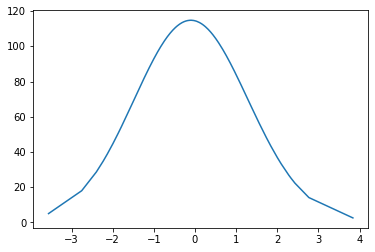

In [6]:
for normal in norm_list:
    plotto.plot(x,normal,'-')
    
norm_sum=np.sum(norm_list,axis=0)

plt.plot(x,norm_sum,'-')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

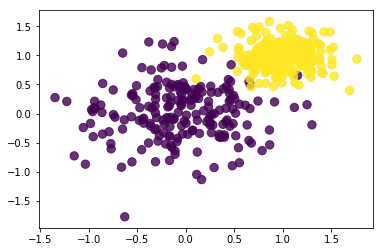

In [7]:
#wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

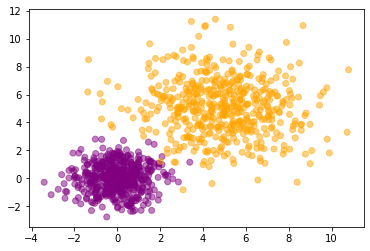

In [8]:
dim=1000
np_tot=np.concatenate((np.random.normal(0,1,dim),np.random.normal(5,2,dim)))
np_tot=np_tot.reshape(dim,2)
#print(np_tot)
datf=pd.DataFrame(np_tot, columns=(['A','B']))
datf['C']=pd.Series(np.concatenate((np.ones(500),np.zeros(500))))
datf

my_color=np.where(datf['C']==0, 'orange', 'purple')

plt.scatter(datf['A'],datf['B'],color=my_color,alpha=0.5)

#sns.relplot(x="A",y="B",hue='C',data=datf)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [10]:
import scipy.stats

Slope:  0.0032597701220305835
Intercept:  -0.15432816763069473


/home/francesco/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


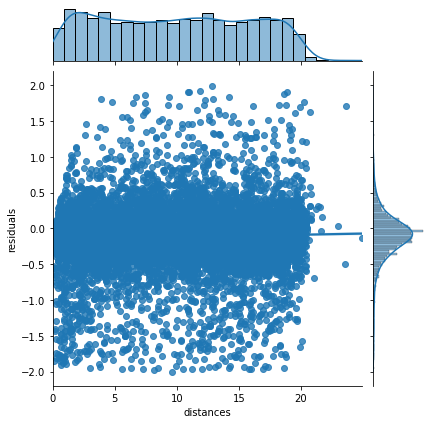

In [15]:
pf=pd.DataFrame(np.load('residuals_261.npy',allow_pickle=True).item())
pf=pf[abs(pf['residuals'])<2]
pf
pf_slope, pf_intercept, pf_rvalue, pf_p, pf_stderr=scipy.stats.linregress(pf['distances'],pf['residuals'])
print('Slope: ',pf_slope)
print('Intercept: ', pf_intercept)

sns.jointplot("distances","residuals", data=pf, kind="reg")

In [54]:
x=np.array([i+0.5 for i in range (20) ])

f_list=[]
e_list=[]
#idx=np.where((pf['distances']>0.5-0.5) & (pf['distances']<=0.5+0.5))
#pf.loc[idx]
#pf[pf['distances']>0][pf['distances']<=0.5+0.5]
for ix in x:
    f_list.append(-pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].mean())
    e_list.append(pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].std())

y=np.array(f_list)
erry=np.array(e_list)

<ipython-input-54-30ee7624816f>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_list.append(-pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].mean())
<ipython-input-54-30ee7624816f>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_list.append(pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].std())
<ipython-input-54-30ee7624816f>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_list.append(-pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].mean())
<ipython-input-54-30ee7624816f>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_list.append(pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].std())
<ipython-input-54-30ee7624816f>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_list.append(-pf[pf['distances']>ix-0.5][pf['distances']<=ix+0.5]['residuals'].mean(

<BarContainer object of 20 artists>

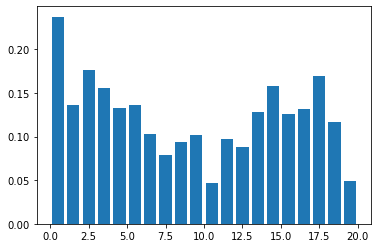

In [55]:
y=np.array(f_list)
erry=np.array(e_list)
plt.bar(x,y)